In [1]:
import Pkg
Pkg.activate(".")
Pkg.resolve()
Pkg.instantiate()
using DataFrames, CSV, Plots, CurveFit, Roots, DifferentialEquations, Optim

  Activating project at `~/Documents/Still evolving/estimu`
  No Changes to `~/Documents/Still evolving/estimu/Project.toml`
  No Changes to `~/Documents/Still evolving/estimu/Manifest.toml`


## Estimated mutation rate increase is maximal for intermediate ciprofloxacin concentrations

In [18]:
MIC = 12
MAC = 8.5
df_Pribis = DataFrame(CSV.File("experimental_data/Pribis_Fig2D.txt"; comment="#"))

Row,cipro_concentration,number_experiments,no_cipro_mutation_rate,range_no,cipro_mutation_rate,range_cipro,fold_induction_mutation_rate,fold_min,fold_max,of_MIC
,Float64,Int64?,Float64,String15,Float64,String15,Float64,Float64,Float64,Float64
1,1.0,4,1.1,"(0.78,1.4)",1.7,"(1.2,2.2)",1.7,1.1,2.4,0.0833333
2,2.0,4,1.1,"(0.78,1.4)",2.3,"(2.0,2.6)",2.2,1.8,2.7,0.166667
3,4.0,4,1.1,"(0.78,1.4)",5.2,"(3.4,7.0)",4.8,4.2,5.3,0.333333
4,8.5,missing,0.62,"(0.51,0.75)",19.0,"(6,50)",30.0,11.0,67.0,0.708333
5,10.0,2,0.63,"(0.55,0.70)",10.0,"(10,11)",17.0,15.0,18.0,0.833333
6,12.0,9,1.2,"(0.92,1.4)",13.0,"(8.1,16)",11.0,7.1,15.0,1.0
7,14.0,2,0.63,"(0.55,0.70)",5.7,"(5.7,5.8)",9.3,8.3,10.0,1.16667


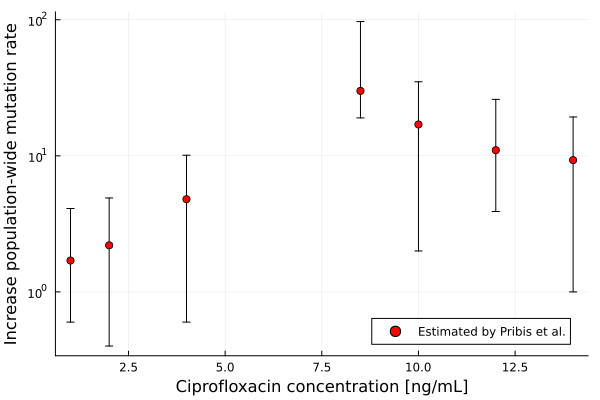

In [113]:
C = df_Pribis.cipro_concentration
M_MLE = df_Pribis.fold_induction_mutation_rate
M_lower = df_Pribis.fold_min
M_upper = df_Pribis.fold_max
P_M = plot(ylab="Increase population-wide mutation rate", xlab="Ciprofloxacin concentration [ng/mL]", yscale=:log10, legend=:bottomright)
scatter!(C, M_MLE, yerror=(M_lower, M_upper), lab="Estimated by Pribis et al.", c=:red)

# Population dynamics with highly-mutating and slowly dividing subpopulation
## 1. Exponential growth

In [20]:
# Population growth dynamics of non-mutants (deterministic)
# Growth of response-off subpopulation: exponential growth with population growth rate = division-death-switching rate, initial population size N0
pop_size_exp(t, N0_off, pop_growth) = N0_off*exp(pop_growth*t)
# Growth of response-on subpopulation: influx from response-off subpopulation plus exponential growth with own net growth rate = division-death rate, initial population size N0_on 
function pop_size_exp(t, N0_off, pop_growth, switching, N0_on, net_growth_on)
    if net_growth_on == pop_growth
        return (N0_off*switching*t + N0_on) * exp(pop_growth*t)
    else
        return N0_off*switching/(pop_growth - net_growth_on) * (exp(pop_growth*t) - exp(net_growth_on*t)) + N0_on*exp(net_growth_on*t)
    end
end

pop_size_exp (generic function with 2 methods)

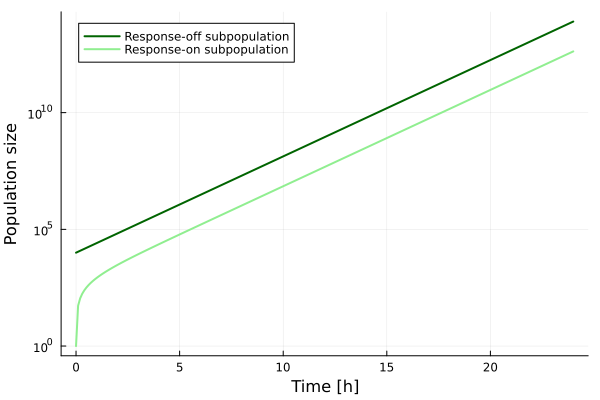

In [47]:
function default_paras()
    global N0_off = 10^4
    global gamma_off = 1.
    global delta_off = 0.
    global switching = 0.05
    global N0_on = 1.
    global gamma_on_rel = 0.
    global delta_on = 0.
    global tf = 24
end
default_paras()
P_popdyn = plot(xlab="Time [h]", ylab="Population size", yscale=:log10, legend=:topleft)
plot!(0:0.1:tf, x -> pop_size_exp(x, N0_off, gamma_off-delta_off-switching), lab="Response-off subpopulation", c=:darkgreen, width=2)
plot!(0:0.1:tf, x -> pop_size_exp(x, N0_off, gamma_off-delta_off-switching, switching, N0_on, gamma_on_rel*gamma_off-delta_on), lab="Response-on subpopulation", c=:lightgreen, width=2)

### How do the population dynamics depend on the antibiotic concentration?

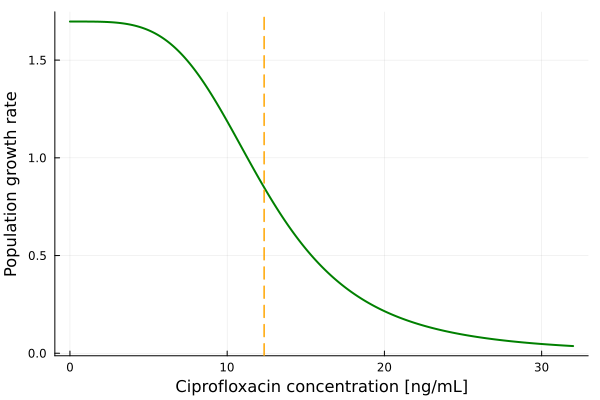

In [100]:
# Population growth rate depending on antibiotic concentration
growth_rate(lambda_max, c, IC50, hill_coeff) = lambda_max/(1+(c/IC50)^hill_coeff)
# Dose-reponse curve from Das et al.
hill_coeff = 4.
C_Das = [0, 3, 4, 5, 6, 8, 10,	12,	16, 19, 24, 30]	
L_Das = [1.7766242417013847, 1.6759786921621884, 1.622073671010411, 1.5935829705158313, 1.4966412849441446, 1.3712351236453877, 1.1687123190092563, 0.8121688962722318, 0.4979127312005524, 0.27448873064044177, 0, 0]
IC50_Das = 12.35
MIC_Das = 19
l = [growth_rate(1., x, IC50_Das, hill_coeff) for x in C_Das]
i, m = linear_fit(l, L_Das)
lambda_max = m
P_lambda = plot(xlab="Ciprofloxacin concentration [ng/mL]", ylab="Population growth rate", legend=:false)
plot!(0:0.1:32, x -> growth_rate(lambda_max, x, IC50_Das, hill_coeff), lab="", c=:green, width=2)
vline!([IC50_Das], lab="IC50", style=:dash, c=:orange, width=1.5)
#vline!([MIC_Das], lab="MIC", style=:dash, c=:red, width=1.5)

In [91]:
MAC_to_IC50(MAC, hill_coeff) = MAC/9^(1/hill_coeff)
IC50 = MAC_to_IC50(MAC, hill_coeff)
println(IC50)

4.907477288111819


0.015999999999999986


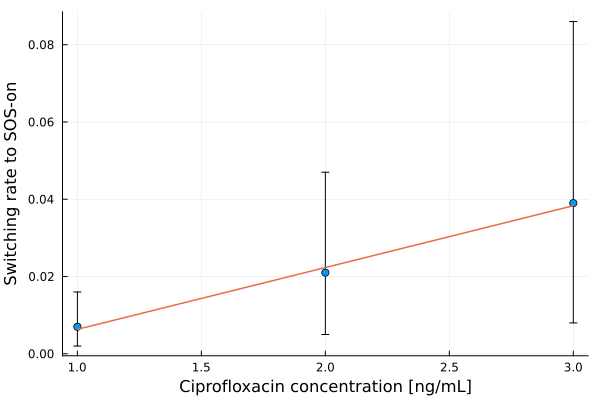

In [102]:
# Switching rate increases with division rate and with antibiotic concentration
switching_rate(gamma_off, c, scaling_factor) = scaling_factor*gamma_off*c
# Estimated switching rate for different ciprofloxacin concentrations from Jaramillo-Riveri et al.
alpha_mean = [0.007, 0.021, 0.039]
alpha_sme = [0.002, 0.005, 0.008]
alpha_0, scaling_factor = linear_fit(1:3, alpha_mean)
println(scaling_factor)
P_alpha = plot(ylab="Switching rate to SOS-on", xlab="Ciprofloxacin concentration [ng/mL]", legend=:false)
scatter!(1:3, alpha_mean, yerror=(alpha_mean.-alpha_sme, alpha_mean.+alpha_sme), lab="Mother machine data Jaramillo-Riveri et al.")
plot!(1:3, x -> alpha_0 + x*scaling_factor, lab="Linear least squares fit", width=1.5)

### Bacteriostatic: antibiotic action through reduced division but without cell death

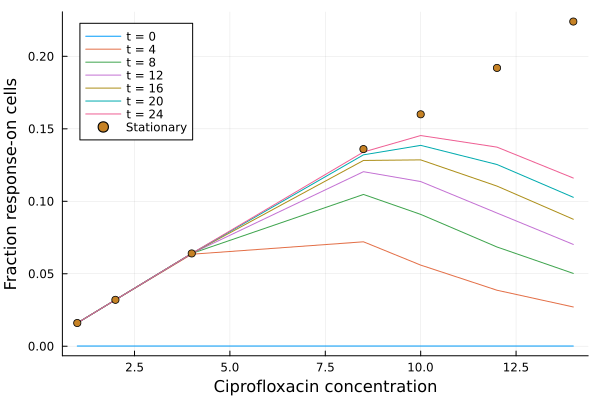

In [104]:
default_paras()
# Calculate the population dynamic parameters depending on the concentration for bacteriostatic drug
function pop_dyn_paras(c)
    # Population growth rate -> dose-repsonse curve
    pop_growth = growth_rate(lambda_max, c, IC50, hill_coeff)
    # Decrease in population growth rate due to change in division rate off-cells and switching rate
    gamma_off = pop_growth/(1 - c*scaling_factor)
    switching = switching_rate(gamma_off, c, scaling_factor)
    # Optionally, change in division rate on-cells (rel. division rate is fixed)
    gamma_on = gamma_off*gamma_on_rel
    return pop_growth, switching, gamma_on
end
function pop_sizes_exp(t, c)
    pop_growth, switching, gamma_on = pop_dyn_paras(c)
    n_on = pop_size_exp(t, N0_off, pop_growth, switching, N0_on, gamma_on-delta_on)
    n_off = pop_size_exp(t, N0_off, pop_growth)
    return n_on, n_off
end
function fraction_on_exp(t, c)
    n_on, n_off = pop_sizes_exp(t, c)
    return n_on / (n_on + n_off)
end
function fraction_on_stat(c)
    pop_growth, switching, gamma_on = pop_dyn_paras(c)
    if gamma_on - delta_on < pop_growth
        return switching/(pop_growth + switching - (gamma_on-delta_on))
    else
        return 1
    end
end
P_f = plot(xlab="Ciprofloxacin concentration", ylab="Fraction response-on cells")
for y in 0:4:24
    plot!(C, x -> fraction_on_exp(y, x), lab="t = $y")
end
scatter!(C, x -> fraction_on_stat(x), lab="Stationary")

(1.6277881160168223e-10, 6.616686416385261e-12)


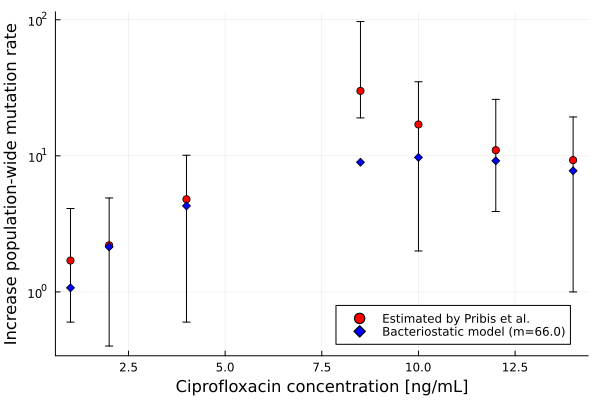

In [114]:
function M_model(P)
    if P[1] < 0. || P[2] < 0.
        return Inf
    else
        global gamma_on_rel = P[1]
        global delta_on = P[2]
        F = [fraction_on_exp(tf, x) for x in C]
        i, m = linear_fit(F[1:3], M_MLE[1:3])
        M = F .* m
        return sum((M[4:end] .- M_MLE[4:end]).^2)
    end
end
res = Optim.optimize(M_model, [0.1/lambda_max, 0.])
gamma_on_rel, delta_on = Optim.minimizer(res)
println((gamma_on_rel, delta_on))
F = [fraction_on_exp(tf, x) for x in C]
i, m = linear_fit(F[1:3], M_MLE[1:3])
M = F .* m
mu_inc = m - 1
scatter!(P_M, C, M, lab="Bacteriostatic model (m=$(round(mu_inc)))", marker=:d, c=:blue)

### Bacteriostatic: antibiotic action through increased death rate

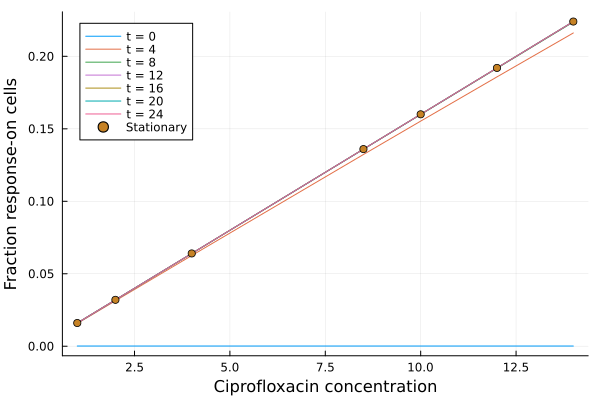

In [106]:
default_paras()
# Calculate the population dynamic parameters depending on the concentration for bacteriostatic drug
function pop_dyn_paras(c, death)
    # Population growth rate -> dose-repsonse curve
    pop_growth = growth_rate(lambda_max, c, IC50, hill_coeff)
    # Change in population growth rate due to cell death -> division rate off-cells is constant
    switching = switching_rate(gamma_off, c, scaling_factor)
    # On-cells have same death rate as off-cells
    delta_on_new = delta_on + gamma_off - switching - pop_growth
    return pop_growth, switching, delta_on_new
end
function pop_sizes_exp(t, c, death)
    pop_growth, switching, delta_on_new = pop_dyn_paras(c, death)
    n_on = pop_size_exp(t, N0_off, pop_growth, switching, N0_on, gamma_off*gamma_on_rel-delta_on_new)
    n_off = pop_size_exp(t, N0_off, pop_growth)
    return n_on, n_off
end
function fraction_on_exp(t, c, death)
    n_on, n_off = pop_sizes_exp(t, c, death)
    return n_on / (n_on + n_off)
end
function fraction_on_stat(c, death)
    pop_growth, switching, delta_on_new = pop_dyn_paras(c, death)
    if gamma_off*gamma_on_rel-delta_on_new < pop_growth
        return switching/(pop_growth + switching - (gamma_off*gamma_on_rel-delta_on_new))
    else
        return 1
    end
end
P_f_d = plot(xlab="Ciprofloxacin concentration", ylab="Fraction response-on cells")
for y in 0:4:24
    plot!(C, x -> fraction_on_exp(y, x, true), lab="t = $y")
end
scatter!(C, x -> fraction_on_stat(x, true), lab="Stationary")

(0.7605948031270269, 0.02223075844085544)


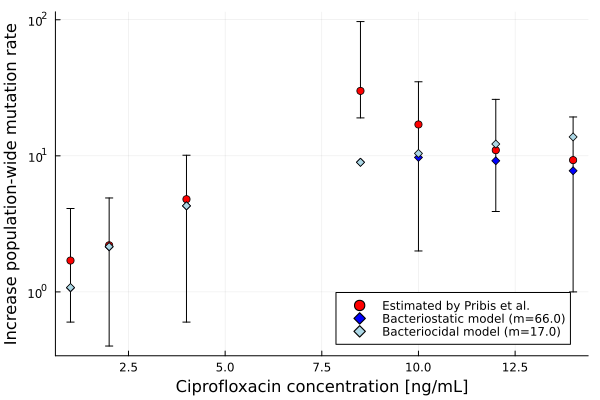

In [115]:
function M_model(P)
    if P[1] < 0. || P[2] < 0.
        return Inf
    else
        global gamma_on_rel = P[1]
        global delta_on = P[2]
        F = [fraction_on_exp(tf, x, true) for x in C]
        i, m = linear_fit(F[1:3], M_MLE[1:3])
        M = F .* m
        return sum((M[4:end] .- M_MLE[4:end]).^2)
    end
end
res = Optim.optimize(M_model, [0.1/lambda_max, 0.])
gamma_on_rel, delta_on = Optim.minimizer(res)
println((gamma_on_rel, delta_on))
F = [fraction_on_exp(tf, x, true) for x in C]
i, m = linear_fit(F[1:3], M_MLE[1:3])
M = F .* m
mu_inc = m - 1
scatter!(P_M, C, M, lab="Bacteriocidal model (m=$(round(mu_inc)))", marker=:d, c=:lightblue)

## 2. Logistic growth (exponential + stationary phase)

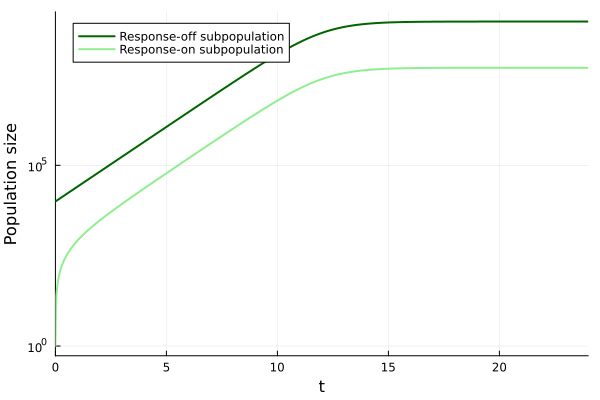

In [13]:
Nf = 10^9
function pop_sizes_log(du, u, p, t)
    n1, n2 = u
    Nf, pop_growth, switching, net_growth_on = p
    du[1] = dn1 = pop_growth * (1 - (n1+n2)/Nf)*n1
    du[2] = dn2 = net_growth_on * (1 - (n1+n2)/Nf)*n2 + switching * (1 - (n1+n2)/Nf)*n1
end
pop_growth = gamma_off - delta_off - switching
net_growth_on = gamma_on_rel*gamma_off - delta_on
n01, n02 = N0_off, N0_on
u0 = [n01, n02]
tspan = (0., tf)
p = [Nf, pop_growth, switching, net_growth_on]
prob = ODEProblem(pop_sizes_log, u0, tspan, p)
sol = solve(prob)
P_popdyn_stat = plot(xlab="Time [h]", ylab="Population size", yscale=:log10, legend=:topleft)
plot!(sol, lab=["Response-off subpopulation" "Response-on subpopulation"], c=[:darkgreen :lightgreen], width=2)